In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

In [58]:
train = pd.read_csv('/content/sample_data/california_housing_train.csv')
test = pd.read_csv('/content/sample_data/california_housing_test.csv')

train.drop(columns=['median_house_value'], axis=1, inplace=True)
test.drop(columns=['median_house_value'], axis=1, inplace=True)

train['is_train'] = 1
test['is_train'] = 0

X = pd.concat([train,test], axis=0)
y = X['is_train']
X.drop('is_train', axis=1, inplace=True)

In [59]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

params = {
        'loss_function': 'Logloss',
        'learning_rate' : 0.05,
        'iterations': 10000,
    }

cat = CatBoostClassifier(**params, random_seed=42)

In [60]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

Fold: 0
X_train.shape:  (16000, 8)
ROC_AUC score:  0.501117156862745


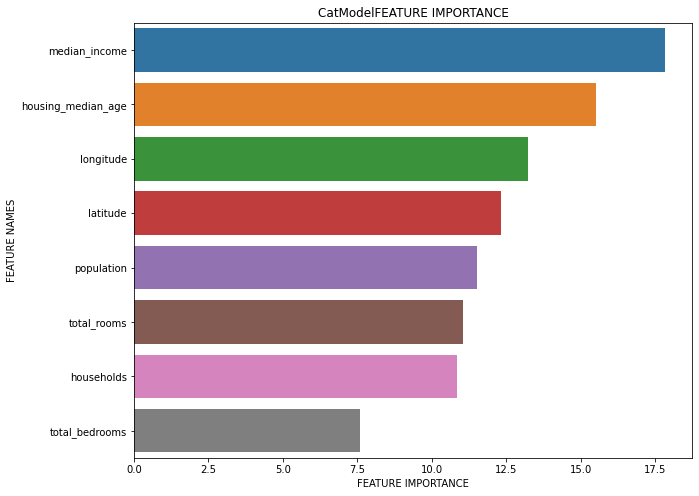

Fold: 1
X_train.shape:  (16000, 8)
ROC_AUC score:  0.529636274509804


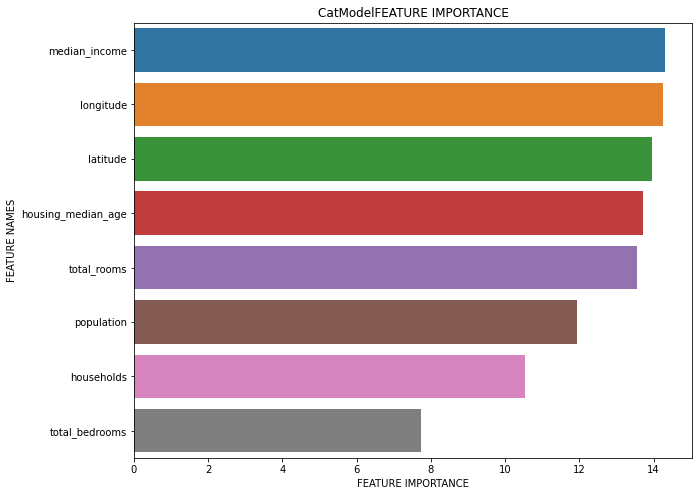

Fold: 2
X_train.shape:  (16000, 8)
ROC_AUC score:  0.5151642156862745


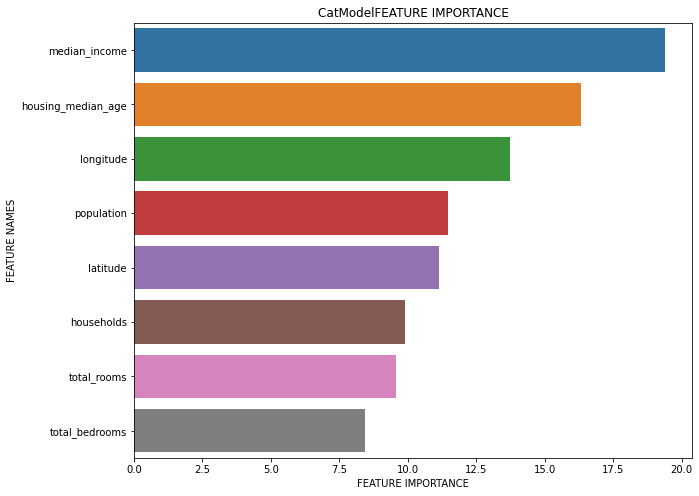

Fold: 3
X_train.shape:  (16000, 8)
ROC_AUC score:  0.5256289215686275


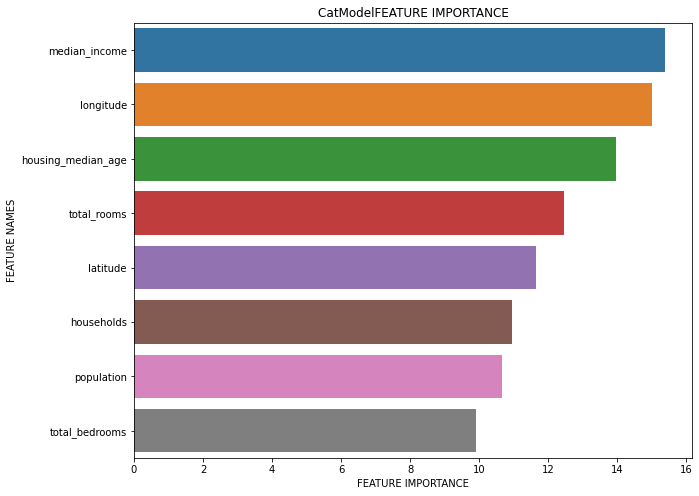

Fold: 4
X_train.shape:  (16000, 8)
ROC_AUC score:  0.5154367647058823


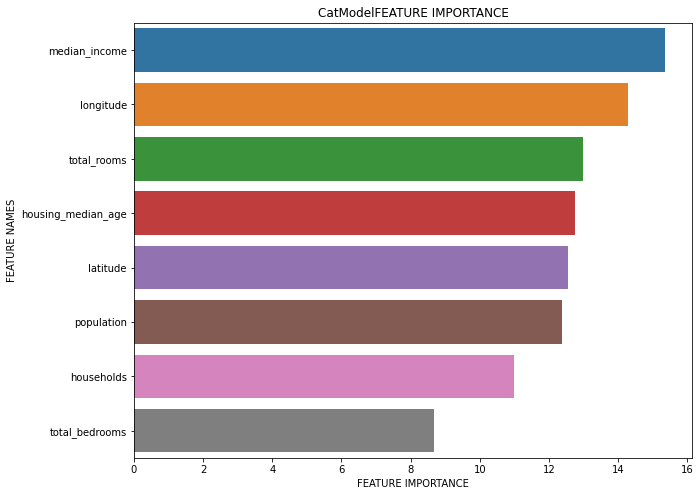

In [61]:
scores = []

for fold, (train_id, test_id) in enumerate(skf.split(X, y)):
  print('Fold:', fold)

  X_train, y_train = X.iloc[train_id], y.iloc[train_id] 
  X_valid, y_valid = X.iloc[test_id], y.iloc[test_id]
  print('X_train.shape: ', X_train.shape)
  
  cat.fit(
      X_train, y_train,
      eval_set=[(X_valid, y_valid)],
      verbose=False,
      early_stopping_rounds=10
      )
  
  valid_pred = cat.predict_proba(X_valid)[:, 1]
  valid_score = roc_auc_score(y_valid, valid_pred)
  print('ROC_AUC score: ', valid_score)
  scores.append(valid_score)

  plot_feature_importance(cat.get_feature_importance(), X_valid.columns, 'CatModel')
  plt.show()